# Grouped By Graph Type CNN Model With Contamination Using Heatmaps With 3x3 Kernel

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [ ]:
# Common settings
img_height = 288
img_width = 512
batch_size = 32

# Get the project root directory
# Try to find project root by looking for "Heatmaps" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Heatmaps" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Heatmaps")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Base dataset path: Heatmaps/organized_by_graph_type (at project root)
base_dataset_path = os.path.join(project_root, "Heatmaps", "organized_by_graph_type")

# Print path for verification
print(f"Project root: {project_root}")
print(f"Base dataset path: {base_dataset_path}")

In [3]:
# Function to create your original CNN model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(img_height, img_width, 3)),  # Color images

        layers.Conv2D(32, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Train and evaluate one fold
def train_and_evaluate(dataset_name, fold, average_results):
    dataset_path = os.path.join(base_dataset_path, dataset_name)

    # Load datasets (RGB)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    # # Convert RGB to grayscale
    # def convert_to_grayscale(image, label):
    #     image = tf.image.rgb_to_grayscale(image)
    #     return image, label
    #
    # train_ds = train_ds.map(convert_to_grayscale)
    # val_ds = val_ds.map(convert_to_grayscale)

    model = create_model()

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop]
    )

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} - Training vs Validation Accuracy - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Training vs Validation Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate on validation set
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Track final epoch accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    average_results["train_accuracies"].append(final_train_acc)
    average_results["val_accuracies"].append(final_val_acc)

    print(f"Fold {fold + 1} Final Train Acc: {final_train_acc:.4f}, Final Val Acc: {final_val_acc:.4f}")


=== Running 5-fold CV for: bar ===
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5037 - loss: 151.0096 - val_accuracy: 0.5548 - val_loss: 0.7231
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5379 - loss: 0.7317 - val_accuracy: 0.5484 - val_loss: 0.6646
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5611 - loss: 0.6784 - val_accuracy: 0.5677 - val_loss: 0.6752
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6382 - loss: 0.6587 - val_accuracy: 0.6129 - val_loss: 0.6524
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5637 - loss: 0.6766 - val_accuracy: 0.6129 - val_loss: 0.6452
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4923 - loss: 0.6716 - val_accuracy: 0.5484 - val_loss: 0.6931
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.

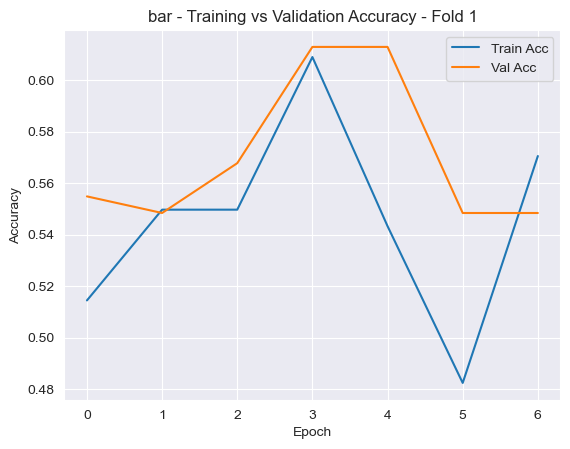

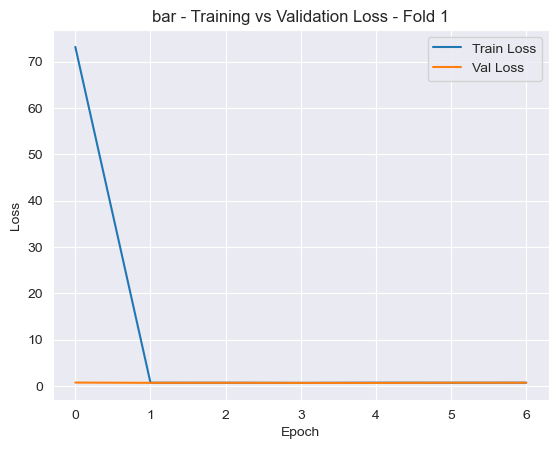

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


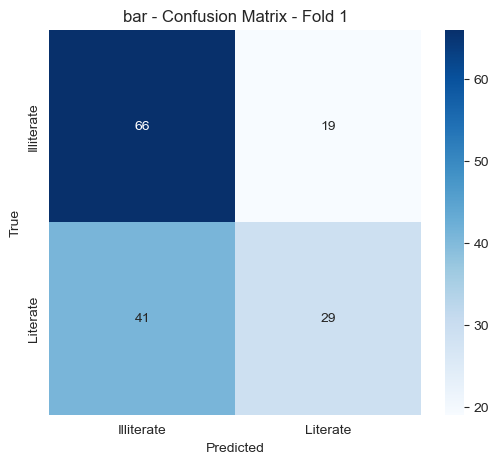

Fold 1 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4899 - loss: 316.8827 - val_accuracy: 0.5419 - val_loss: 0.6870
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4647 - loss: 1.0862 - val_accuracy: 0.5484 - val_loss: 0.6930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5723 - loss: 0.7278 - val_accuracy: 0.5419 - val_loss: 0.6987
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5729 - loss: 1.8607 - val_accuracy: 0.5032 - val_loss: 0.6974
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5663 - loss: 0.6919 - val_accuracy: 0.5484 - val_loss: 0.6919


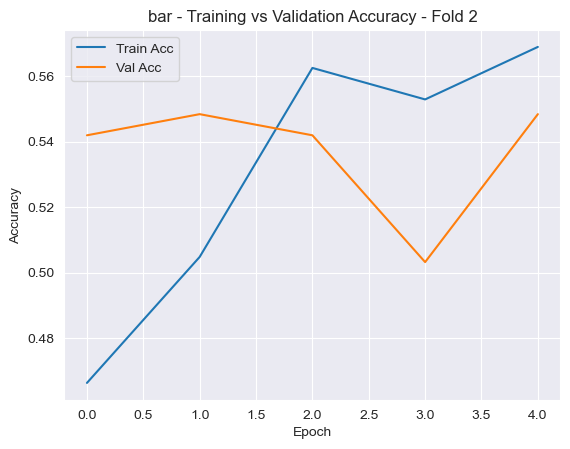

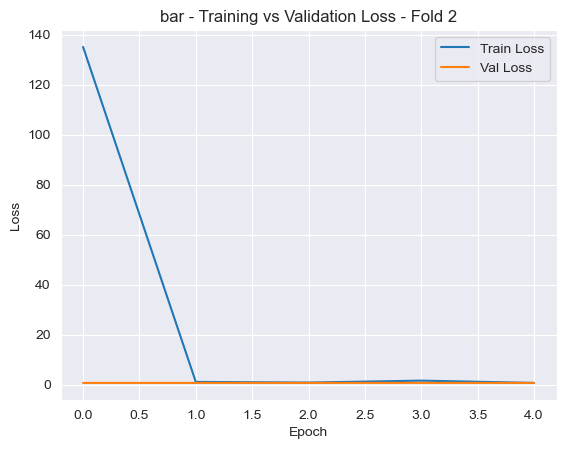

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


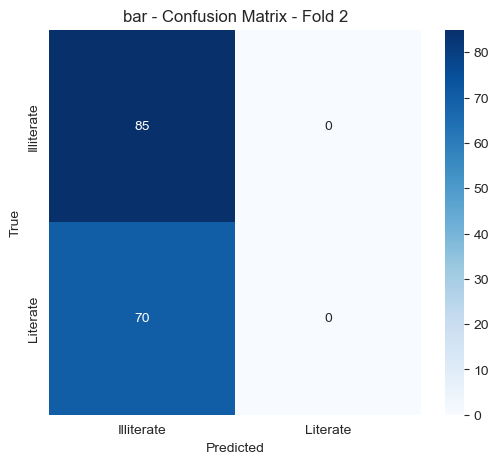

Fold 2 Final Train Acc: 0.5689, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5431 - loss: 114.8542 - val_accuracy: 0.5484 - val_loss: 0.6930
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5571 - loss: 0.6928 - val_accuracy: 0.5484 - val_loss: 0.6923
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5754 - loss: 0.6916 - val_accuracy: 0.5484 - val_loss: 0.6916
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6090 - loss: 0.6886 - val_accuracy: 0.5484 - val_loss: 0.6907


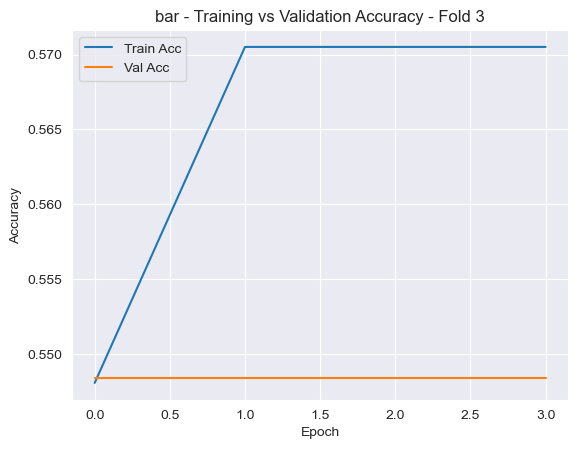

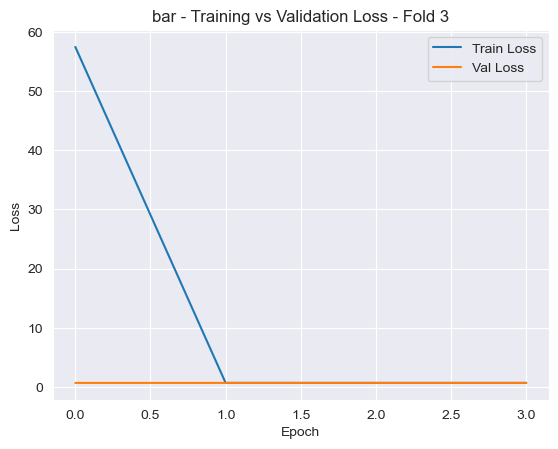

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


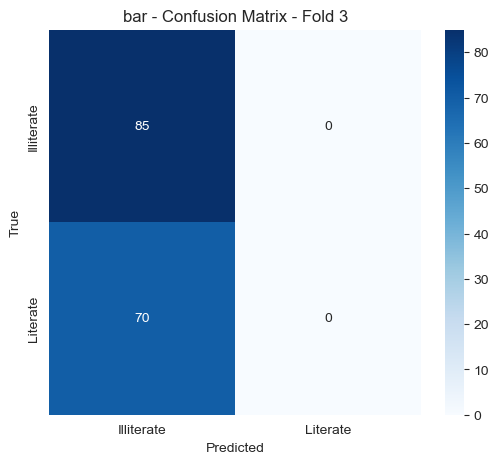

Fold 3 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5274 - loss: 116.8902 - val_accuracy: 0.5419 - val_loss: 0.7812
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5774 - loss: 0.7055 - val_accuracy: 0.5484 - val_loss: 0.6922
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5754 - loss: 0.6912 - val_accuracy: 0.5484 - val_loss: 0.6910
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6090 - loss: 0.6873 - val_accuracy: 0.5484 - val_loss: 0.6899
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5718 - loss: 0.6883 - val_accuracy: 0.5484 - val_loss: 0.6894


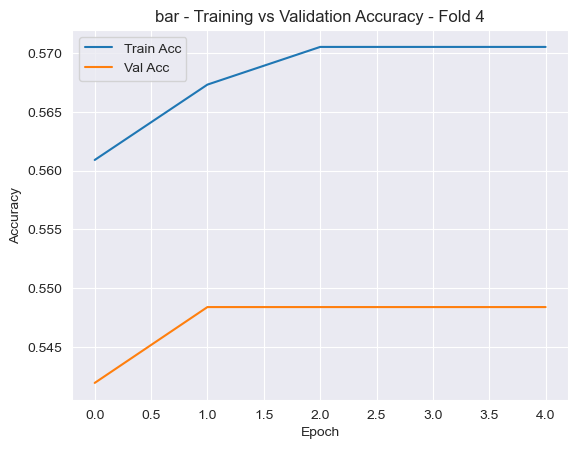

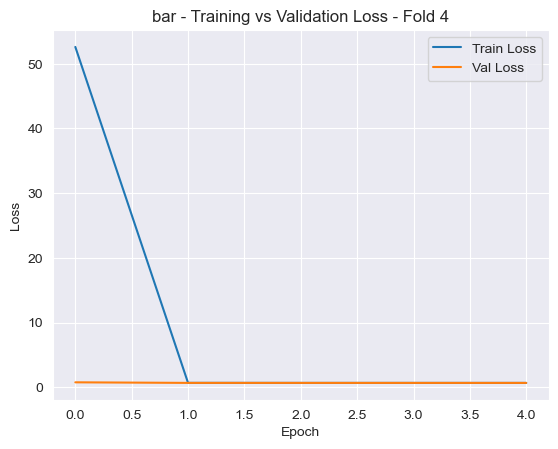

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


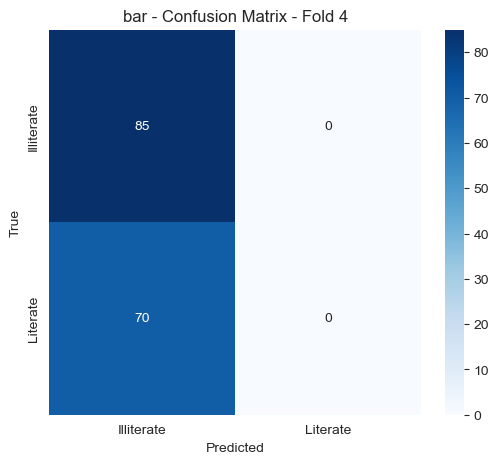

Fold 4 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5355 - loss: 135.6256 - val_accuracy: 0.5355 - val_loss: 0.6889
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6062 - loss: 0.6890 - val_accuracy: 0.5484 - val_loss: 0.6926
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5754 - loss: 0.6917 - val_accuracy: 0.5484 - val_loss: 0.6914
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6090 - loss: 0.6884 - val_accuracy: 0.5484 - val_loss: 0.6902
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5718 - loss: 0.6879 - val_accuracy: 0.5484 - val_loss: 0.6896


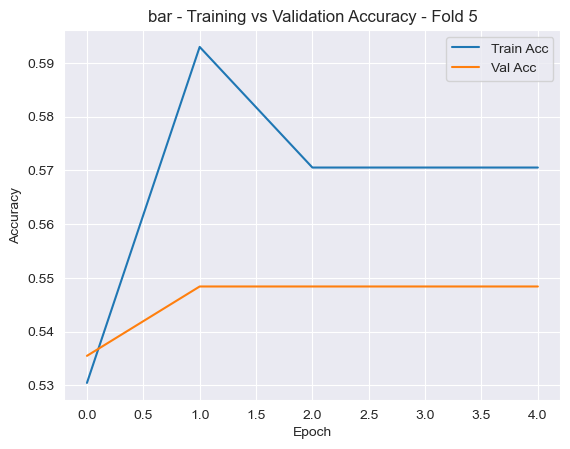

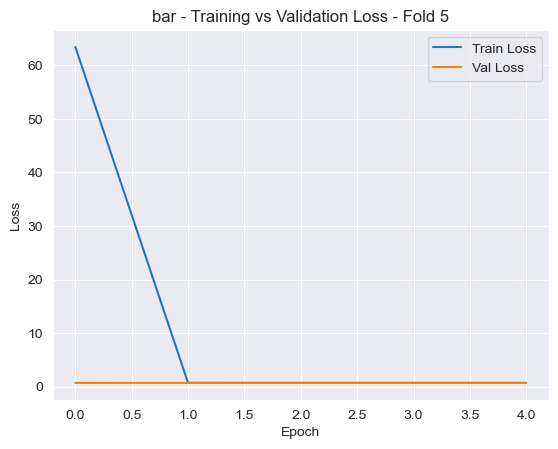

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


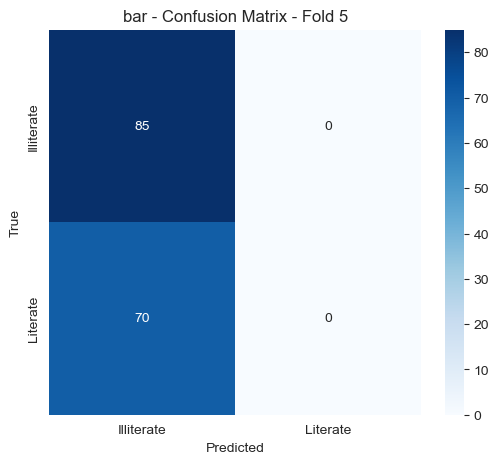

Fold 5 Final Train Acc: 0.5705, Final Val Acc: 0.5484

=== Running 5-fold CV for: line ===
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4828 - loss: 532.2911 - val_accuracy: 0.5614 - val_loss: 0.6930
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5572 - loss: 0.6930 - val_accuracy: 0.5614 - val_loss: 0.6929
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5483 - loss: 0.6929 - val_accuracy: 0.5526 - val_loss: 0.6968
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5531 - loss: 0.6984 - val_accuracy: 0.5614 - val_loss: 0.6924


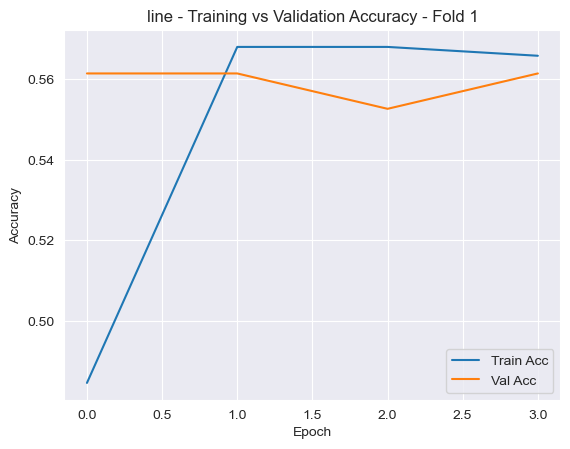

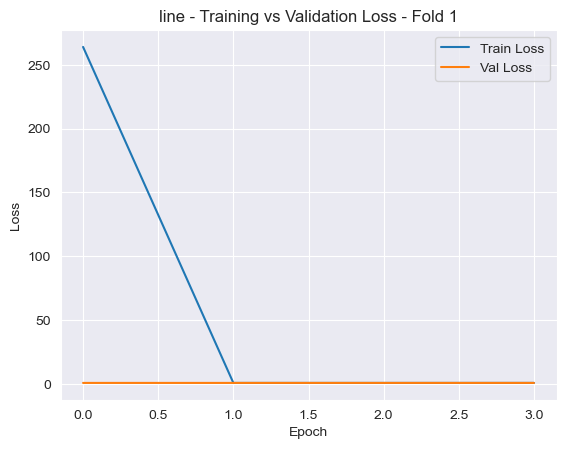

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


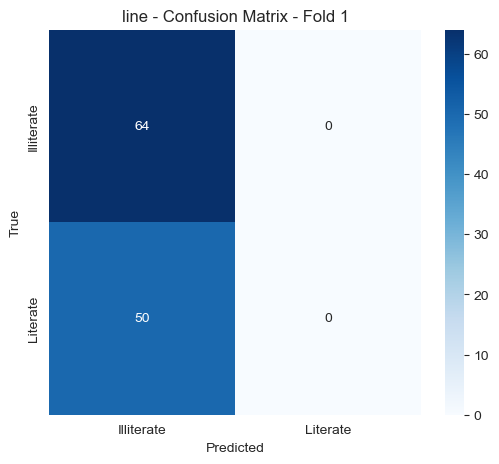

Fold 1 Final Train Acc: 0.5658, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5136 - loss: 164.5481 - val_accuracy: 0.5877 - val_loss: 0.7888
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5738 - loss: 0.7814 - val_accuracy: 0.5614 - val_loss: 0.6928
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5483 - loss: 0.6929 - val_accuracy: 0.5614 - val_loss: 0.6924
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5540 - loss: 0.6924 - val_accuracy: 0.5614 - val_loss: 0.6919


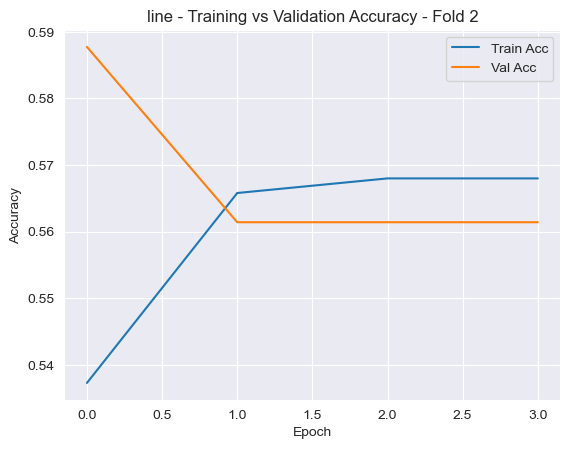

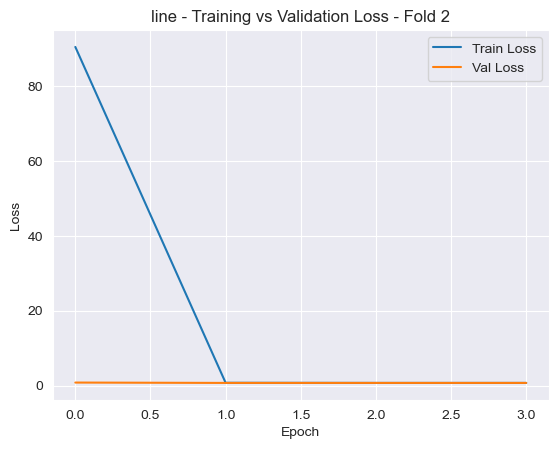

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


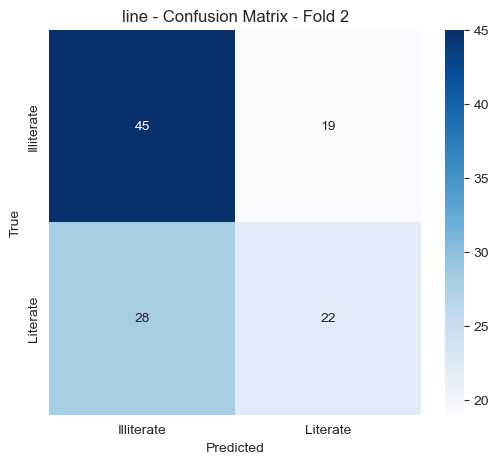

Fold 2 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5291 - loss: 302.3539 - val_accuracy: 0.5614 - val_loss: 2.2106
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5415 - loss: 1.5615 - val_accuracy: 0.4474 - val_loss: 0.6935
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5069 - loss: 0.6930 - val_accuracy: 0.5088 - val_loss: 0.6926
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5669 - loss: 0.6844 - val_accuracy: 0.5439 - val_loss: 0.6901


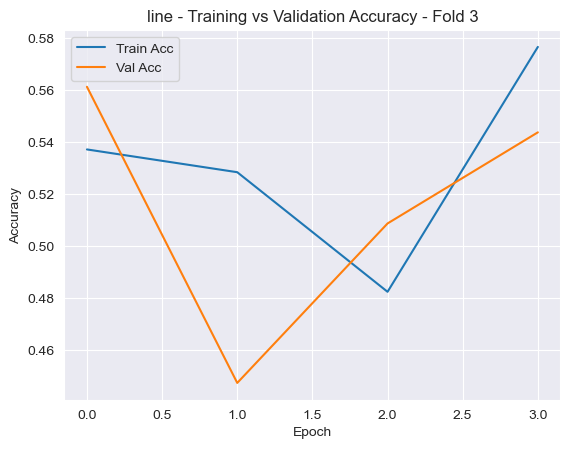

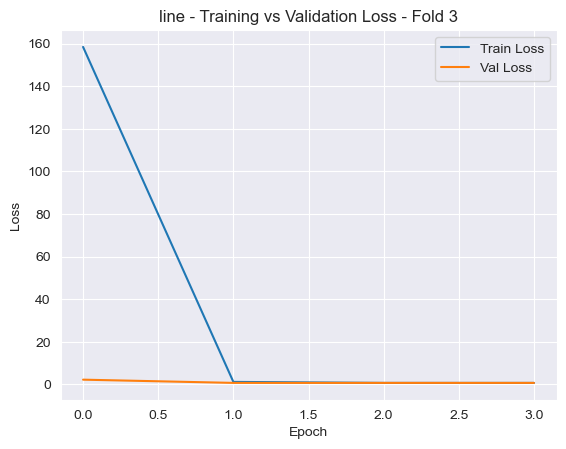

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


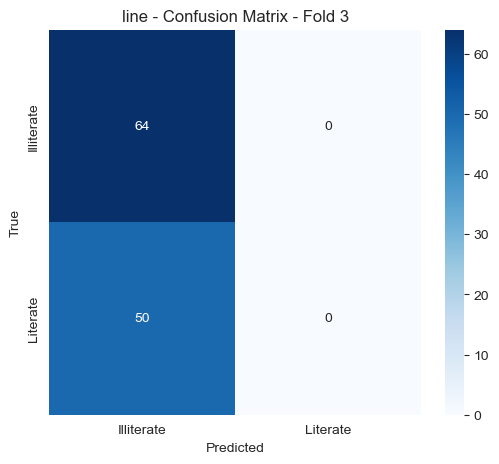

Fold 3 Final Train Acc: 0.5768, Final Val Acc: 0.5439
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5494 - loss: 166.4656 - val_accuracy: 0.6316 - val_loss: 0.6727
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6516 - loss: 0.6592 - val_accuracy: 0.5614 - val_loss: 0.6928
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5483 - loss: 0.6927 - val_accuracy: 0.5614 - val_loss: 0.6921
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5540 - loss: 0.6920 - val_accuracy: 0.5614 - val_loss: 0.6912


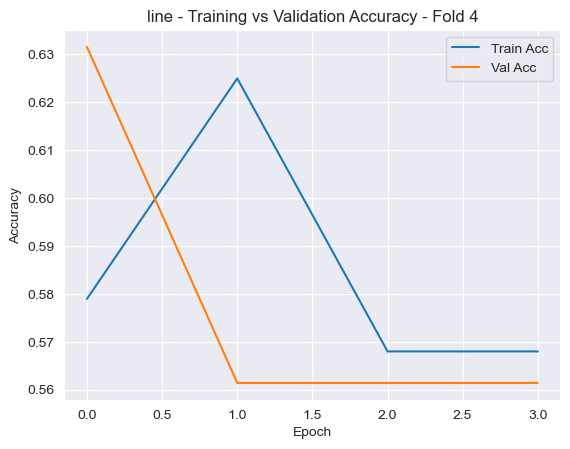

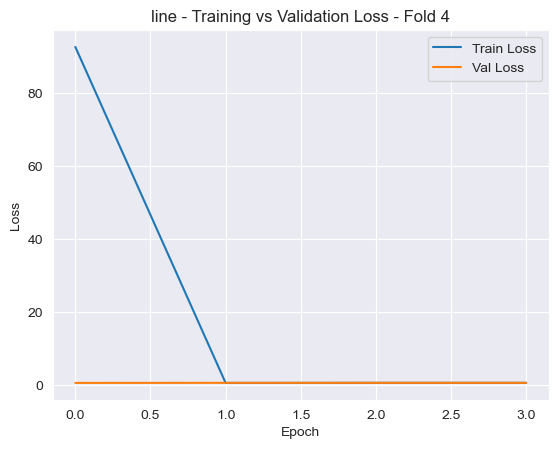

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


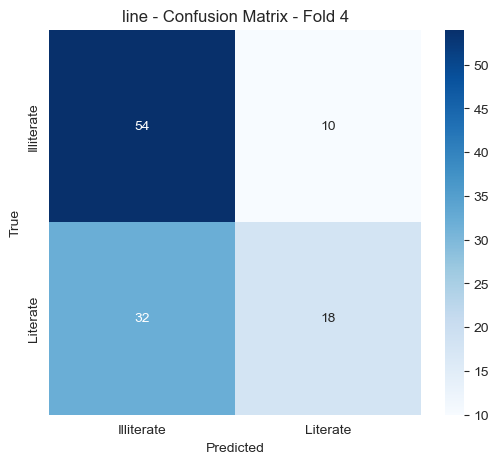

Fold 4 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5728 - loss: 202.2564 - val_accuracy: 0.6316 - val_loss: 0.8462
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5812 - loss: 0.8526 - val_accuracy: 0.4649 - val_loss: 0.7003
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5812 - loss: 0.6855 - val_accuracy: 0.5175 - val_loss: 0.6688
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6429 - loss: 0.6158 - val_accuracy: 0.6579 - val_loss: 0.5986
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7315 - loss: 0.5111 - val_accuracy: 0.6842 - val_loss: 0.6005
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7509 - loss: 0.5039 - val_accuracy: 0.6754 - val_loss: 0.6183
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/s

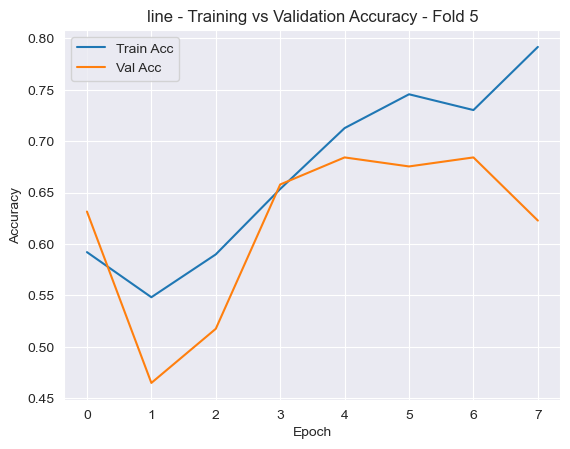

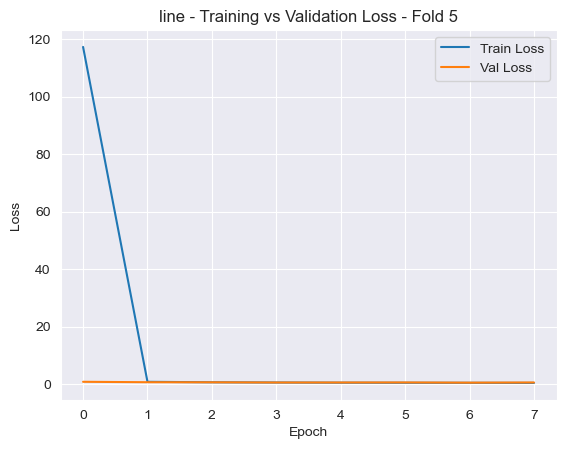

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


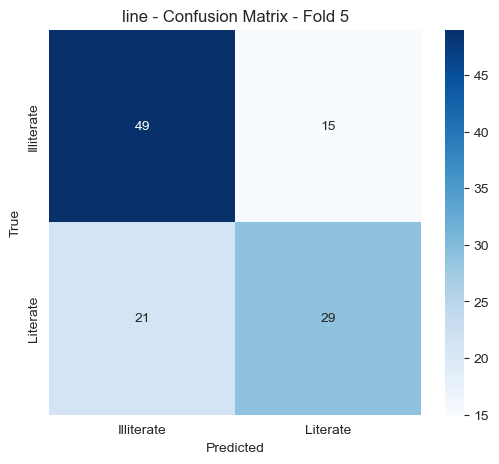

Fold 5 Final Train Acc: 0.7917, Final Val Acc: 0.6228

=== Running 5-fold CV for: pie ===
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3960 - loss: 1151.3480 - val_accuracy: 0.6000 - val_loss: 56.2812
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5421 - loss: 61.0093 - val_accuracy: 0.6333 - val_loss: 4.5635
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4446 - loss: 75.8873 - val_accuracy: 0.4000 - val_loss: 21.9908
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5692 - loss: 9.8346 - val_accuracy: 0.7000 - val_loss: 0.9089
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5308 - loss: 4.0133 - val_accuracy: 0.4000 - val_loss: 0.6602
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6037 - loss: 0.6796 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 7/10
4/4 ━━━━━━━━

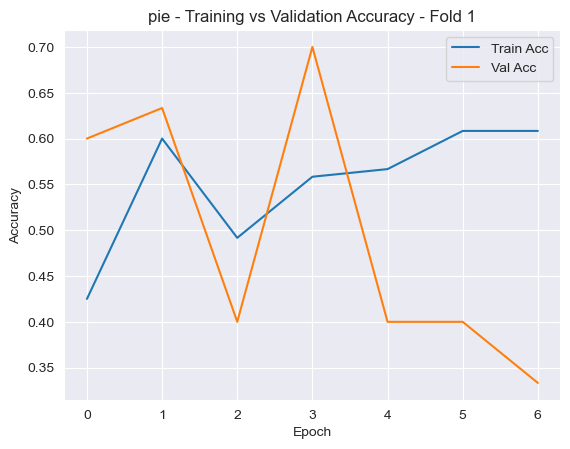

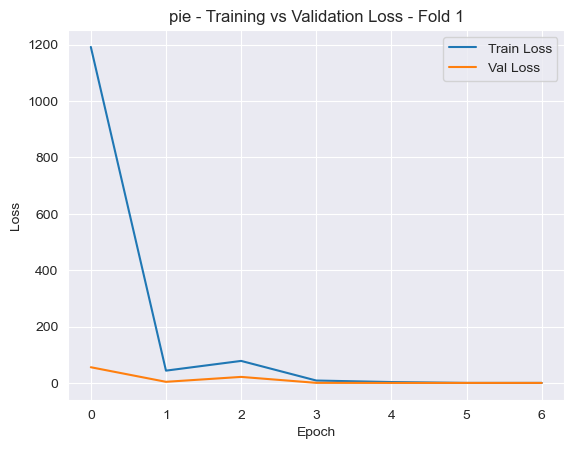

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


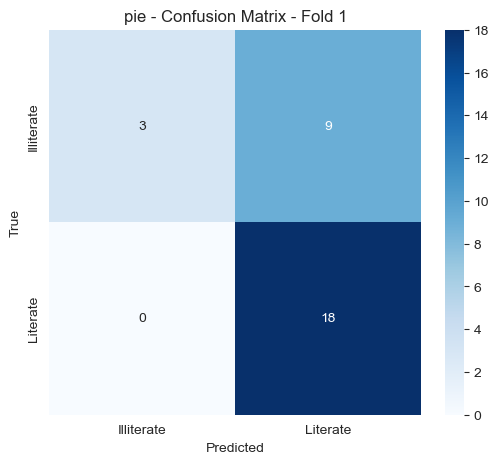

Fold 1 Final Train Acc: 0.6083, Final Val Acc: 0.3333
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5263 - loss: 199.2041 - val_accuracy: 0.6000 - val_loss: 34.4523
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5150 - loss: 24.3832 - val_accuracy: 0.4000 - val_loss: 3.7606
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7144 - loss: 1.0646 - val_accuracy: 0.5667 - val_loss: 0.6810
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7006 - loss: 0.5986 - val_accuracy: 0.6000 - val_loss: 1.1511


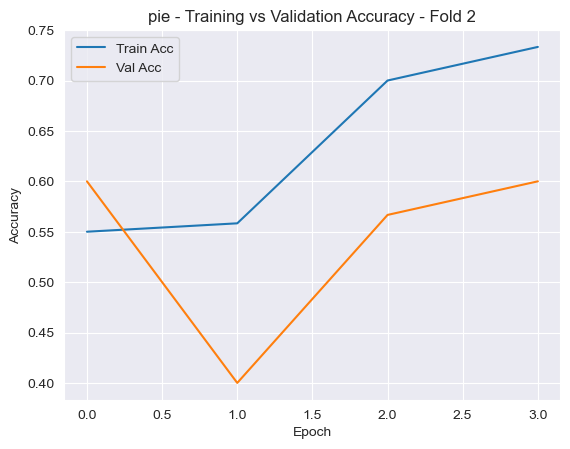

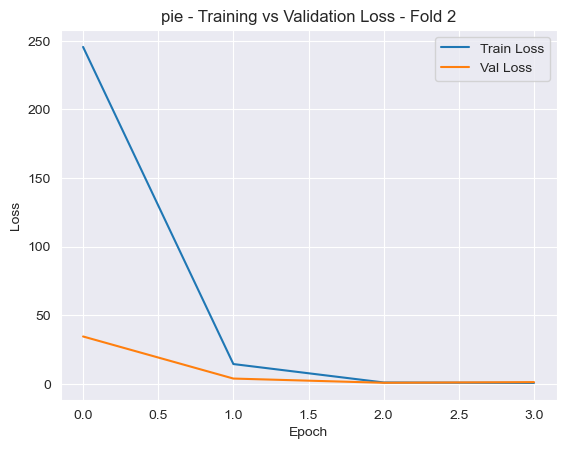

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


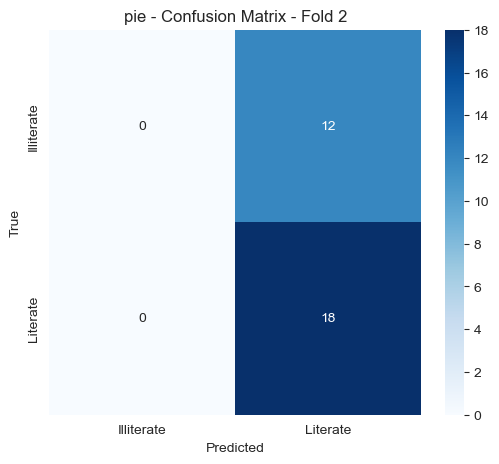

Fold 2 Final Train Acc: 0.7333, Final Val Acc: 0.6000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5733 - loss: 195.4852 - val_accuracy: 0.6000 - val_loss: 16.0783
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4585 - loss: 13.9595 - val_accuracy: 0.4667 - val_loss: 3.1865
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7229 - loss: 1.9525 - val_accuracy: 0.7667 - val_loss: 0.6811
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6248 - loss: 0.9598 - val_accuracy: 0.5333 - val_loss: 0.7225
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6467 - loss: 0.6666 - val_accuracy: 0.4000 - val_loss: 0.6933
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6037 - loss: 0.6929 - val_accuracy: 0.4000 - val_loss: 0.6934


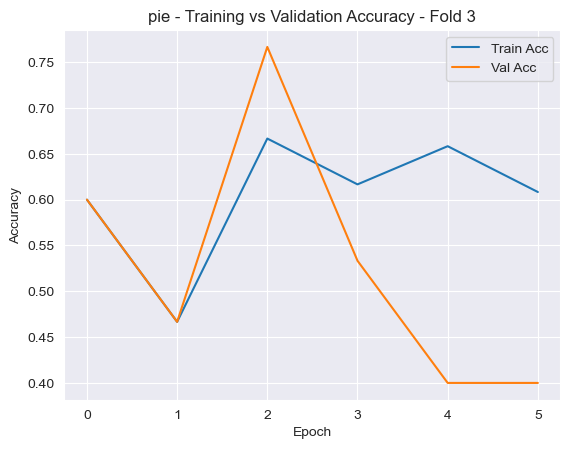

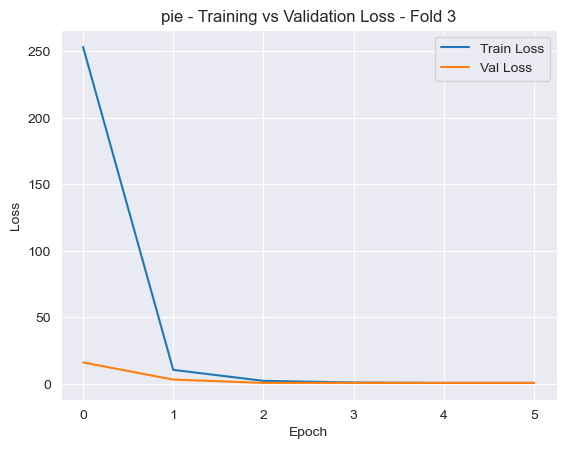

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


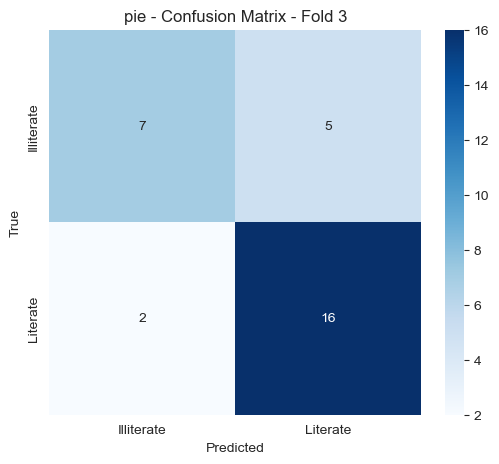

Fold 3 Final Train Acc: 0.6083, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4625 - loss: 793.7745 - val_accuracy: 0.6000 - val_loss: 12.4107
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5319 - loss: 15.2184 - val_accuracy: 0.6333 - val_loss: 1.0973
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6194 - loss: 2.5072 - val_accuracy: 0.4667 - val_loss: 0.7371
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6194 - loss: 0.7045 - val_accuracy: 0.6333 - val_loss: 0.6574
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6165 - loss: 0.6610 - val_accuracy: 0.5333 - val_loss: 0.6714


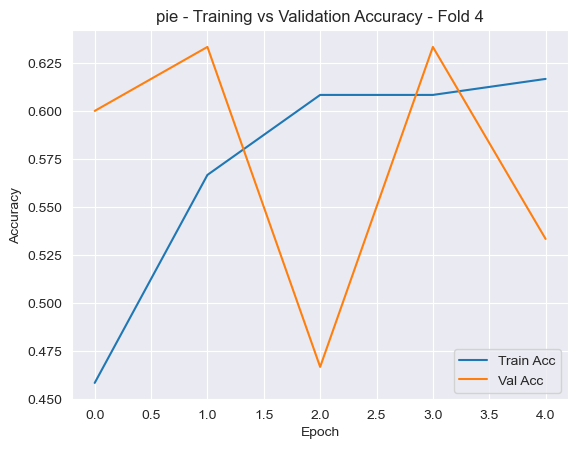

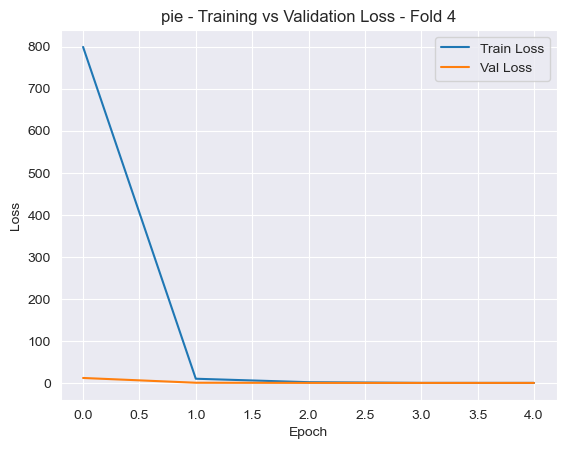

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


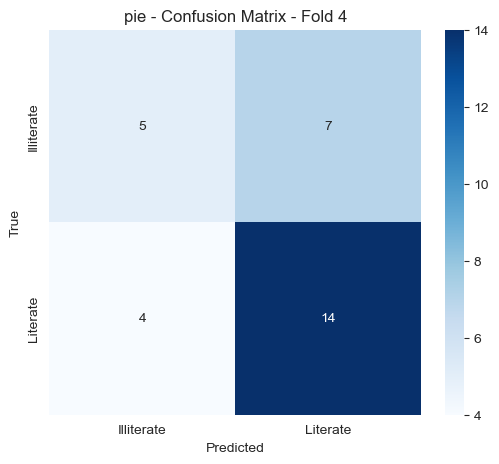

Fold 4 Final Train Acc: 0.6167, Final Val Acc: 0.5333
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4848 - loss: 733.7444 - val_accuracy: 0.6000 - val_loss: 32.8710
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4387 - loss: 21.2890 - val_accuracy: 0.6000 - val_loss: 0.7795
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4835 - loss: 2.1530 - val_accuracy: 0.4000 - val_loss: 3.6788
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5923 - loss: 2.1070 - val_accuracy: 0.6000 - val_loss: 0.6657


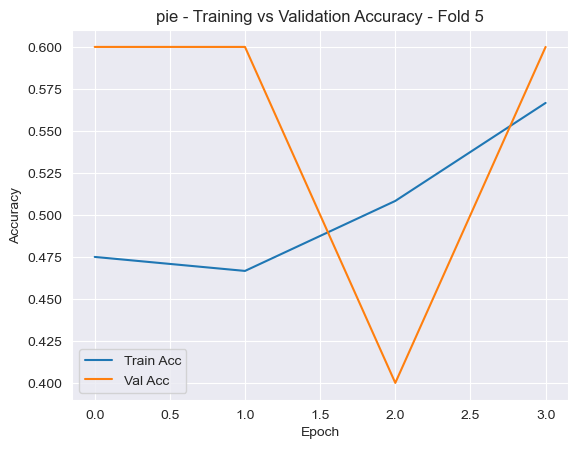

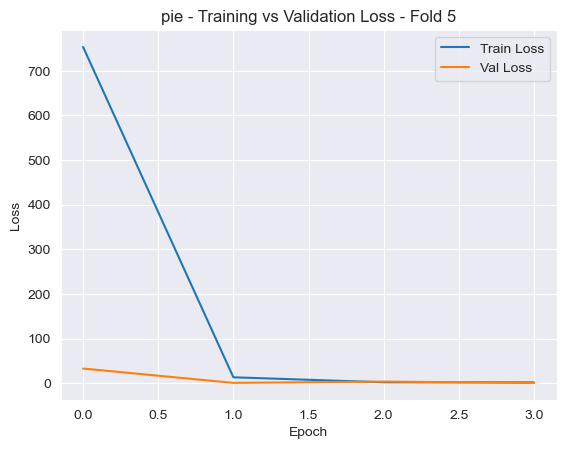

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


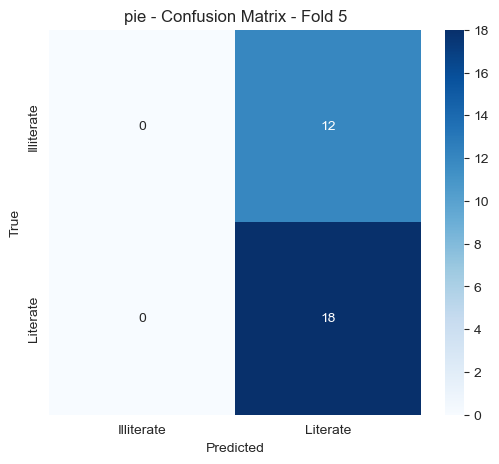

Fold 5 Final Train Acc: 0.5667, Final Val Acc: 0.6000


In [7]:
# Track results for all datasets
all_results = {}

# Perform training and collect fold-wise accuracies
for dataset_name in ["bar", "line", "pie"]:
    print(f"\n=== Running 5-fold CV for: {dataset_name} ===")
    average_results = {
        "train_accuracies": [],
        "val_accuracies": []
    }

    for fold in range(5):
        train_and_evaluate(dataset_name, fold, average_results)

    # Compute and store means
    all_results[dataset_name] = {
        "mean_train": np.mean(average_results["train_accuracies"]),
        "mean_val": np.mean(average_results["val_accuracies"])
    }

In [8]:
# Print summary after all training is done
print("\n=== Summary of Average Accuracies by Graph Type ===")
for dataset_name, result in all_results.items():
    print(f"\nGraph Type: {dataset_name}")
    print(f"→ Average Train Accuracy: {result['mean_train']:.4f}")
    print(f"→ Average Validation Accuracy: {result['mean_val']:.4f}")


=== Summary of Average Accuracies by Graph Type ===

Graph Type: bar
→ Average Train Accuracy: 0.5702
→ Average Validation Accuracy: 0.5484

Graph Type: line
→ Average Train Accuracy: 0.6140
→ Average Validation Accuracy: 0.5702

Graph Type: pie
→ Average Train Accuracy: 0.6267
→ Average Validation Accuracy: 0.4933
